In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def train_and_tune_and_evaluate_model(X, y, model, param_grid, standardize=True, resample=True, scoring='recall', cv=5, random_state=42):
    # Stratified split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

    # Standardize features
    if standardize:
      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)

    # Apply SMOTE to the scaled training data
    if resample:
        smote = SMOTE(random_state=random_state)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    # Combine the model and scaler into a single pipeline
    pipe = [('scaler', StandardScaler()), ('model', model)] if standardize else [('model', model)]
    pipeline = Pipeline(pipe)

    # Create the GridSearchCV object with StratifiedKFold
    stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=stratified_cv)
    grid_search.fit(X_train, y_train)

    # Extracting the best estimator and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Evaluate on multiple metrics using the scaled test data
    y_pred = best_model.predict(X_test)
    y_scores = best_model.predict_proba(X_test)[:, 1]

    scores = {
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'auc_roc': roc_auc_score(y_test, y_scores)
    }

    # Plotting the performance of various parameter combinations
    results = pd.DataFrame(grid_search.cv_results_)
    for param in param_grid:
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=results, x=f'param_{param}', y='mean_test_score')
        plt.title(f'Performance for different values of {param}')
        plt.ylabel(scoring)
        plt.xlabel(param)
        plt.show()

    print("Best Model:", best_model)
    print("Scores:", scores)
    print("Best Params:", best_params)

    return best_model, scores, best_params

In [6]:
df = pd.read_csv('company_bankruptcy.csv')
X = df.drop(['Bankrupt?'], axis=1)
y = df['Bankrupt?']

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


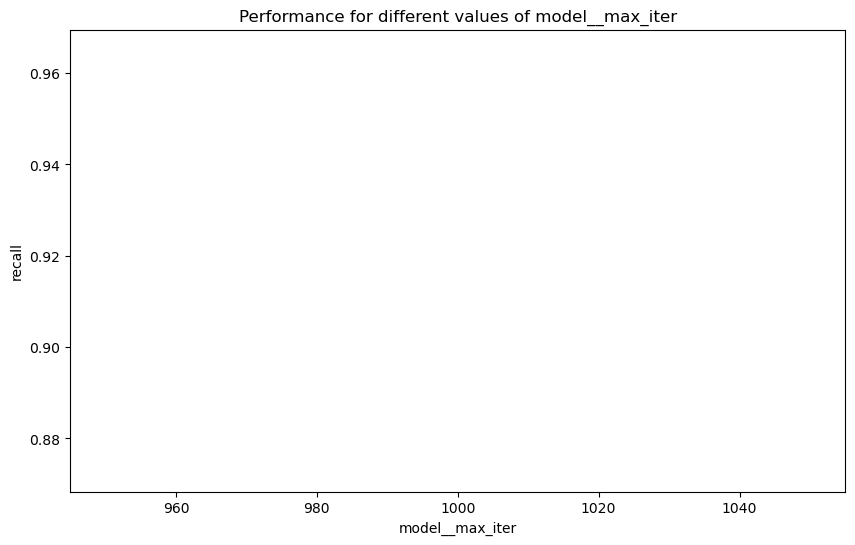

Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=1000))])
Scores: {'accuracy': 0.8819648093841642, 'confusion_matrix': array([[1169,  151],
       [  10,   34]]), 'recall': 0.7727272727272727, 'auc_roc': 0.8918732782369145}
Best Params: {'model__max_iter': 1000}


In [8]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

param_grid_lr = {
    'model__C': np.logspace(-4, 4, 20),
    'model__solver': ['liblinear'],
    'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'model__class_weight': [None],
    'model__max_iter': [1000]
}

best_model_lr, scores_lr, best_params_lr = train_and_tune_and_evaluate_model(X, y, LogisticRegression(), param_grid_lr)